#Import the libraries and read the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
iptv = pd.read_csv('/content/drive/MyDrive/STC datasets/IPTV.csv')

In [4]:
iptv.head()

,Unnamed: 0,date_,user_id_maped,program_name,duration_seconds,program_class,season,episode,program_desc,program_genre,series_title,hd,original_name
0,1,2017-05-27,26138,100 treets,40,MOVIE,0,0,Drama Movie100 Streets,Drama,0,0,100 treets
1,3,2017-05-21,7946,Moana,17,MOVIE,0,0,Animation MovieMoana (HD),Animation,0,1,Moana
2,4,2017-08-10,7418,The Mermaid Princess,8,MOVIE,0,0,Animation MovieThe Mermaid Princess (HD),Animation,0,1,The Mermaid Princess
3,5,2017-07-26,19307,The Mermaid Princess,76,MOVIE,0,0,Animation MovieThe Mermaid Princess (HD),Animation,0,1,The Mermaid Princess
4,7,2017-07-07,15860,Churchill,87,MOVIE,0,0,Biography MovieChurchill (HD),Biography,0,1,Churchill


**Dataset description:**

Program name: The epsiode title.

Original name: The series/movie title.

Date_: the date when the program was watched by the user.

User_id_maped: Virtual user id.

Program class: A movie or series

Program genre: The  main genre of the program.

Duration seconds: The duration of the program in seconds.

Season: The season number.

Episode: The episode number.

Program description: Description of the program.

Series title: The title of the series.

HD: wether the program is in HD resolution or not.



# **Cleaning the data**

**Checking for missing data**

In [6]:
iptv.count()

Unnamed: 0          3598607
date_               3598607
user_id_maped       3598607
program_name        3598607
duration_seconds    3598607
program_class       3598607
season              3598607
episode             3598607
program_desc        3554642
program_genre       3598607
series_title        3598607
hd                  3598607
original_name       3598607
dtype: int64

There are missing values in the program description columns. Because this column is not important in this analysis, we will drop it.

In [7]:
iptv.drop(columns=['program_desc'], inplace=True)

**Delete the tab at the end of the program name and original name**

In [8]:
iptv.program_name = iptv.program_name.apply(lambda x: x.removesuffix(' '))
iptv.original_name = iptv.original_name.apply(lambda x: x.removesuffix(' '))

#Data Visualization

**Do people watched more movies than series?**

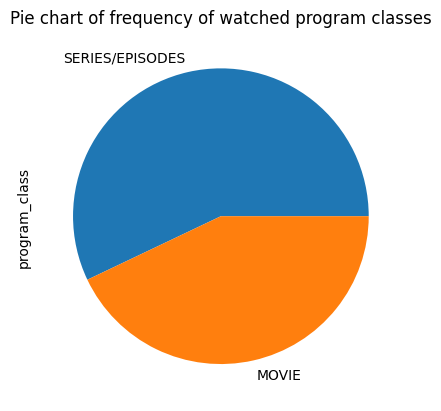

In [9]:
iptv.program_class.value_counts().plot(kind='pie', title='Pie chart of frequency of watched program classes' )
plt.show()

**Watched using HD or not?**

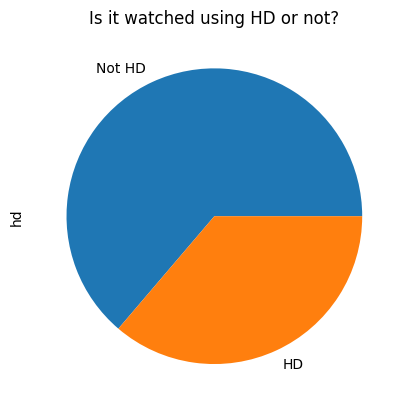

In [10]:
iptv.hd.value_counts().plot(kind='pie', labels=['Not HD','HD'], title='Is it watched using HD or not?')
plt.show()

Only third of the programs are watched in HD resolution.

**What are the most watched program geners**

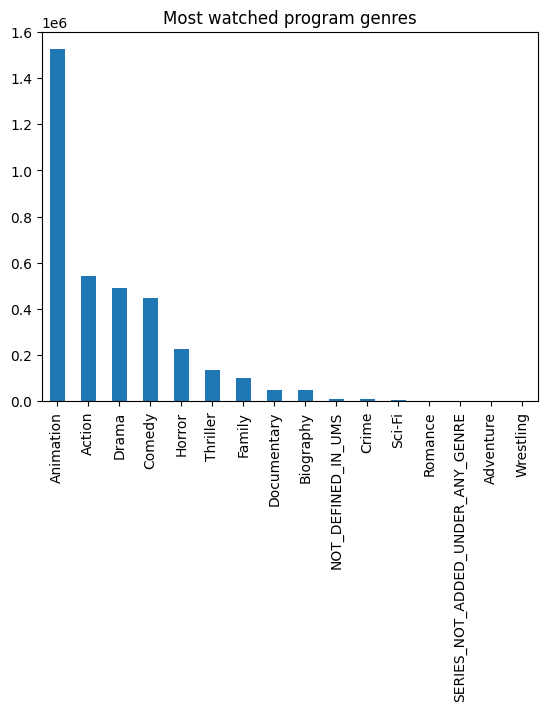

In [11]:
iptv.program_genre.value_counts().plot(kind='bar', title='Most watched program genres')
plt.show()

People watch Animation far more than they watch other genres.

**What are the top 5 movies**

In [12]:
movies = iptv[(iptv['program_class']=='MOVIE')]

In [13]:
top_5_movies = movies['original_name'].value_counts()[:5]

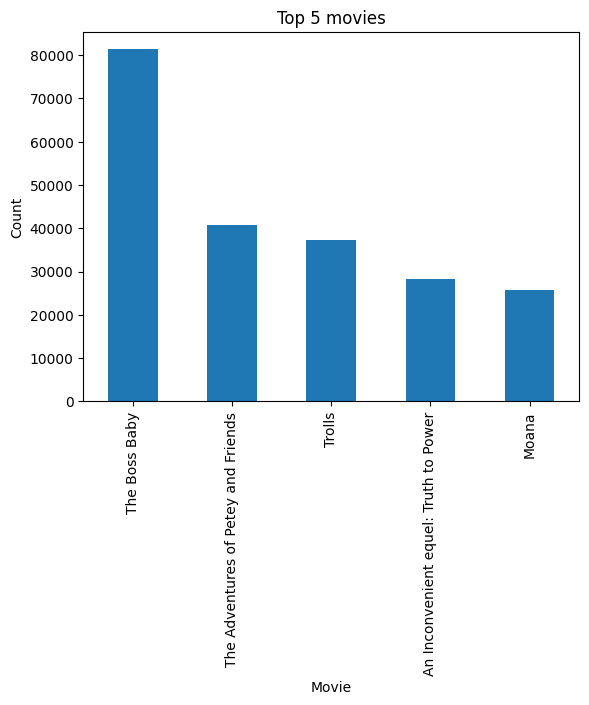

In [14]:
top_5_movies.plot(kind='bar')
plt.title('Top 5 movies')
plt.xlabel('Movie')
plt.ylabel('Count')
plt.show()


**What are the top 5 series**

In [15]:
series = iptv[(iptv['program_class']=='SERIES/EPISODES')]

In [16]:
top_5_series = series['original_name'].value_counts()[:5]

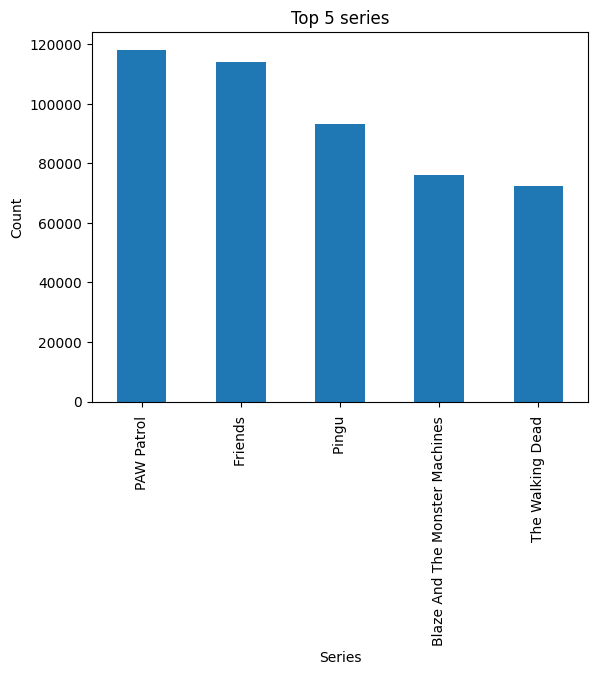

In [17]:
top_5_series.plot(kind='bar')
plt.title('Top 5 series')
plt.xlabel('Series')
plt.ylabel('Count')
plt.show()


**When do people watch more? weekday or weekends?**

In [19]:
#convert the date column into date time object to falcilitate its manipulation
iptv.date_ = pd.to_datetime(iptv['date_'])

In [20]:
days = iptv.date_.dt.day_name()

In [21]:
days = days.value_counts()

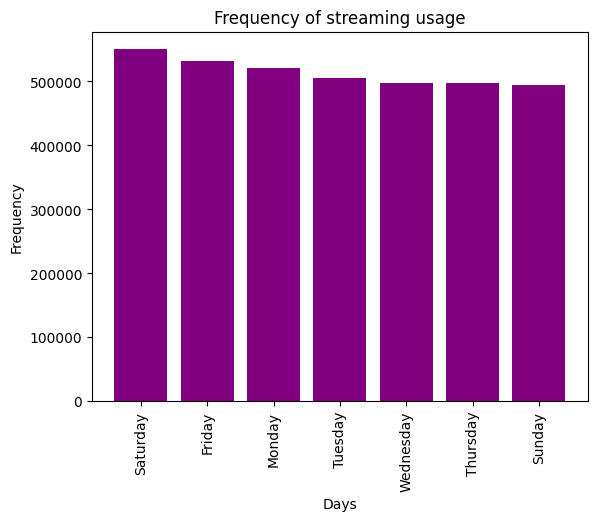

In [23]:
plt.bar(days.index, days, color='purple')
plt.title('Frequency of streaming usage')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.xticks(ticks = np.arange(7), rotation=90)
plt.show()

From the bar graph above, we can see that, people tend to watch a little bit more during weekends.

**What program class do people watch during weekday, and weekend?**


<Axes: xlabel='Day,program_class'>

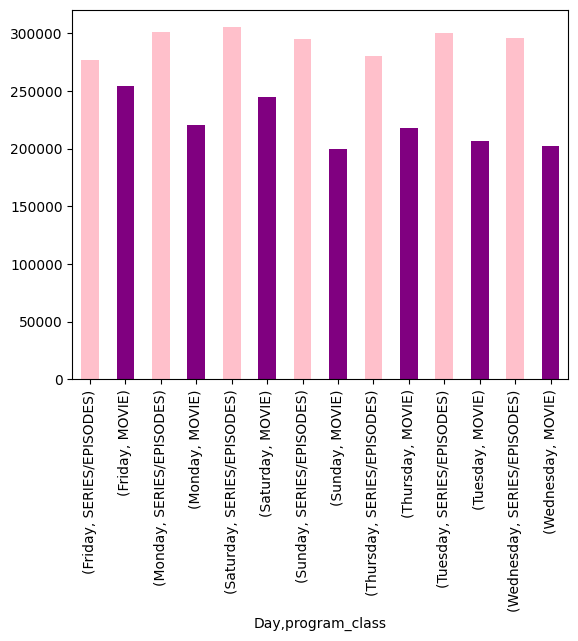

In [71]:
iptv['Day'] = iptv.date_.dt.day_name()
iptv.groupby('Day').program_class.value_counts().plot(kind='bar',color=['pink','purple'],stacked=True)

People tend generally to watch series rather than movies.

#Recommendation system
In this section, we're goining to build a recommendation system using KNN algorithm.
The recommmeder system is hybird, content and collaberated based filtering.

First step is to prepare the important data for the model. The important data are user id maped, original name, program genre, progrm class, , duration, series title


In [26]:
training_data = iptv.drop(columns=['Unnamed: 0', 'date_', 'season', 'episode', 'hd', 'program_name'])

Convert categorical data into numerical using LabelEncoder

In [27]:
from sklearn.preprocessing import OrdinalEncoder


In [45]:
orEncoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
orEncoder.fit(training_data)
encoded_2 = orEncoder.transform(training_data)
encoded_2 = pd.DataFrame(encoded_2)

start training

In [29]:
from sklearn.neighbors import NearestNeighbors

In [30]:
knn = NearestNeighbors(n_neighbors= 6)
knn.fit(encoded_2)

NearestNeighbors(n_neighbors=6)

In [31]:
def getNeighborsNames(indices):
  neighbors = [encoded_2.iloc[i] for i in indices]
  neighbors = orEncoder.inverse_transform(neighbors[0])
  names =[]
  for row in neighbors:
    names.append(row[-1])#The last column is the original name column
  return set(names)


**An example row of the training data.
This row will be used to get the user id for collaberative filtering or the program information for the content-based filtering.**

user_id_maped                       7418

program_name        The Mermaid Princess

duration_seconds                       8

program_class                      MOVIE

program_genre                  Animation

series_title                           0

**Predict for a user**

Using the user id for the collaberative filtering.

In [32]:
test = pd.Series([7418,'','','','',''])
test = orEncoder.transform([test])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(


In [33]:
distance,  indices= knn.kneighbors(test)

In [34]:
indices

array([[ 410023,  527677,  314265,  385575, 3324599,  348219]])

In [46]:
getNeighborsNames(indices)

{'100 treets',
 '12 Rounds : Reloaded',
 '17 Again',
 '30 Minutes Or Less',
 '48 Hrs'}

**Predict for a program.**

Using content-based filtering.


In [47]:
test = pd.Series(['',8,'MOVIE','Animation',0,'The Mermaid Princess'])
test = orEncoder.transform([test])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(


In [48]:
distance,  indices= knn.kneighbors(test)

In [49]:
getNeighborsNames(indices)

{'The Man with the Iron Heart',
 'The Manchurian Candidate',
 'The Mermaid Princess',
 'The Messenger',
 'The Nut Job : Nutty by Nature'}